(12,)
(1, 12)
[[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]
[-0.5432108]
<class 'numpy.ndarray'>
-1.2819155895214296
41.33
Predicted Value= 40.048084410478566


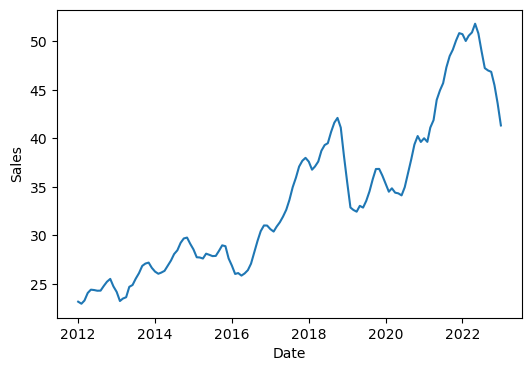

RMSE: 0.9448045065279675
MAE: 0.7872222222222223
R2 Score: 0.9736510227369348
(12,)
(1, 12)
[[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]
[-0.5432108]
<class 'numpy.ndarray'>
-1.2819155895214296
41.33
Predicted Value= 40.048084410478566
(12,)
(1, 12)
[[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]
[-0.5432108]
<class 'numpy.ndarray'>
-1.2819155895214296
41.33
Predicted Value= 40.048084410478566


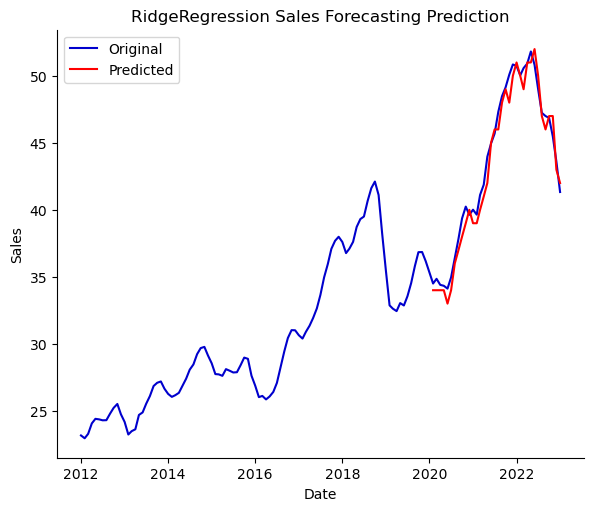

In [73]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import datetime


import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import os


from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import Ridge





def get_diff(data):
    """Returns the dataframe with a column for sales difference between each
    month.  
    """
    data['sales_diff'] = data.Sales.diff()
    data = data.dropna()
    
    data.to_csv('stationary_df.csv')

    return data


def generate_supervised(data):
    """Generates a csv file where each row represents a month and columns
    include sales, the dependent variable, and prior sales for each lag. Based
    on EDA, 12 lag features are generated. Data is used for regression modeling.
    Output df:
    month1  sales  lag1  lag2  lag3 ... lag11 lag12
    month2  sales  lag1  lag2  lag3 ... lag11 lag12
    """
    supervised_df = data.copy()

    #create column for each lag
    for i in range(1, 13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)

    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)

    supervised_df.to_csv('model_df.csv', index=False)


def tts(data):
    data = data.drop(['Sales','Date'],axis=1)
    train, test = data[0:-36].values, data[-36:].values
    
    return train, test

def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

def undo_scaling(y_pred, x_test, scaler_obj):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    
    x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

def load_original_df():
    #load in original dataframe without scaling applied
    #original_df = pd.read_csv(file_path)
    original_df=data
    original_df.Date = pd.to_datetime(original_df.Date)
    
    return original_df
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    
    sales_dates = list(original_df[-37:].Date)
    act_sales = list(original_df[-37:].Sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['Date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result


def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.Sales[-36:], unscaled_df.pred_value[-36:]))
    mae = mean_absolute_error(original_df.Sales[-36:], unscaled_df.pred_value[-36:])
    r2 = r2_score(original_df.Sales[-36:], unscaled_df.pred_value[-36:])
    #model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x=original_df.Date, y=original_df.Sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(x=results.Date, y=results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    canvas = FigureCanvasTkAgg(fig, master=bottom_frame)
    canvas.draw()
    canvas.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
    
   # plt.savefig(f'{model_name}_forecast.png')  
    

def run_model(train_data, test_data, model, model_name,t=0):
   
        X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)

        mod = model
        mod.fit(X_train, y_train)
        predictions = mod.predict(X_test)

        # Undo scaling to compare predictions against original data
        original_df = load_original_df()

        unscaled = undo_scaling(predictions, X_test, scaler_object)

        unscaled_df = predict_df(unscaled, original_df)

        get_scores(unscaled_df, original_df, model_name)

        plot_results(unscaled_df, original_df, model_name)
    
        

    
def loaddata():
    file_path = filedialog.askopenfilename()
    print("Selected file:", file_path)
    
    data=pd.read_csv(file_path)
    print(data)
    stationary_df = get_diff(data)
    print(stationary_df)
    generate_supervised(stationary_df)
    model_df = pd.read_csv('model_df.csv')
    train, test = tts(model_df)
def view():
    fig = plt.figure(figsize=(6, 4), dpi=100)
    plt.plot(data['Date'], data['Sales'])

    # Set the x-axis label to 'Date' and the y-axis label to 'Sales'
    plt.xlabel('Date')
    plt.ylabel('Sales')

    # Show the chart
    plt.show()
    canvas = FigureCanvasTkAgg(fig, master=bottom_frame)
    canvas.draw()
    canvas.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

def train():
    train, test = tts(model_df)
    run_model(train, test,Ridge(alpha = 0.5), 'RidgeRegression')
def predict():
    df=pd.read_csv('model_df.csv')
    
    t=np.array([-2.280000000000001,-1.8699999999999974,-1.3800000000000026,-0.14000000000000057,-0.240000000000002,-1.759999999999998,-1.8200000000000003,-1.0,0.8999999999999986,0.3400000000000034,0.5399999999999991,-0.7000000000000028])

    print(t.shape)
    #t=np.array([-1.8699999999999974,-1.3800000000000026,-0.14000000000000057,-0.240000000000002,-1.759999999999998,-1.8200000000000003,-1.0,0.8999999999999986,0.3400000000000034,0.5399999999999991,-0.7000000000000028,0.759999999999998])
    t=t.reshape(1,-1)
    print(t.shape)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(t)

    ts=scaler.transform(t)
    print(ts)

    tsy=mod.predict(ts)
    #print(tsy.reshape(-1, 1))
    print(tsy)
    tem=np.array(tsy)
    a=np.append(tsy,ts)

    print(type(a))
    scaler1 = MinMaxScaler(feature_range=(-1, 1))

    scaler1 = scaler.fit(test)

    oy=scaler1.inverse_transform(a.reshape(1,-1))
    print(oy[0,0])
    last_i=df.tail(1).index[0]
    print(df['Sales'][last_i])
    pv=oy[0,0]+df['Sales'][last_i]
    
    print("Predicted Value=",oy[0,0]+df['Sales'][last_i])
    wps="Predicted Value for Upcoming month:={:.2f}".format(pv)
    label = tk.Label(top_frame,text=wps)
    label.pack(side=tk.LEFT,padx=10, pady=10)

# Create the main window
window = tk.Tk()
window.title("Inventory Forecasting")
window.geometry("800x600")

# Create the top frame for buttons
top_frame = tk.Frame(window, bg="white")
top_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

# Create the buttons
loaddatabutton = tk.Button(top_frame, text="LOAD", command=loaddata, bg="red", fg="white")
loaddatabutton.pack(side=tk.LEFT, padx=10, pady=10)

viewbutton = tk.Button(top_frame, text="VIEW", command=view, bg="green", fg="white")
viewbutton.pack(side=tk.LEFT, padx=10, pady=10)

trainbutton = tk.Button(top_frame, text="TRAIN", command=train, bg="blue", fg="white")
trainbutton.pack(side=tk.LEFT, padx=10, pady=10)

predictbutton = tk.Button(top_frame, text="PREDICT", command=predict, bg="orange", fg="white")
predictbutton.pack(side=tk.LEFT, padx=10, pady=10)

# Create the bottom frame for the graph
bottom_frame = tk.Frame(window, bg="white")
bottom_frame.pack(side=tk.BOTTOM, fill=tk.BOTH, expand=True)



# Start the Tkinter event loop
window.mainloop()




 











In [ ]:
ifdate=input("Enter date in m/d/yyyy:")
ifdate= pd.to_datetime(ifdate)
print(ifdate)
ndf=model_df
ndf['Date']

In [67]:

df=pd.read_csv('model_df.csv')
print(df)
t=np.array([-2.280000000000001,-1.8699999999999974,-1.3800000000000026,-0.14000000000000057,-0.240000000000002,-1.759999999999998,-1.8200000000000003,-1.0,0.8999999999999986,0.3400000000000034,0.5399999999999991,-0.7000000000000028])

print(t.shape)
#t=np.array([-1.8699999999999974,-1.3800000000000026,-0.14000000000000057,-0.240000000000002,-1.759999999999998,-1.8200000000000003,-1.0,0.8999999999999986,0.3400000000000034,0.5399999999999991,-0.7000000000000028,0.759999999999998])
t=t.reshape(1,-1)
print(t.shape)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(t)

ts=scaler.transform(t)
print(ts)

tsy=mod.predict(ts)
#print(tsy.reshape(-1, 1))
print(tsy)
tem=np.array(tsy)
a=np.append(tsy,ts)

print(type(a))
scaler1 = MinMaxScaler(feature_range=(-1, 1))

scaler1 = scaler.fit(test)

oy=scaler1.inverse_transform(a.reshape(1,-1))
print(oy[0,0])
last_i=df.tail(1).index[0]
print(df['Sales'][last_i])
print("Predicted Value=",oy[0,0]+df['Sales'][last_i])

          Date  Sales  sales_diff  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  \
0     2/1/2013  23.23       -0.94  -0.57  -0.77   0.29   0.43   0.49   0.01   
1     3/1/2013  23.48        0.25  -0.94  -0.57  -0.77   0.29   0.43   0.49   
2     4/1/2013  23.62        0.14   0.25  -0.94  -0.57  -0.77   0.29   0.43   
3     5/1/2013  24.69        1.07   0.14   0.25  -0.94  -0.57  -0.77   0.29   
4     6/1/2013  24.88        0.19   1.07   0.14   0.25  -0.94  -0.57  -0.77   
..         ...    ...         ...    ...    ...    ...    ...    ...    ...   
115   9/1/2022  47.00       -0.24  -1.76  -1.82  -1.00   0.90   0.34   0.54   
116  10/1/2022  46.86       -0.14  -0.24  -1.76  -1.82  -1.00   0.90   0.34   
117  11/1/2022  45.48       -1.38  -0.14  -0.24  -1.76  -1.82  -1.00   0.90   
118  12/1/2022  43.61       -1.87  -1.38  -0.14  -0.24  -1.76  -1.82  -1.00   
119   1/1/2023  41.33       -2.28  -1.87  -1.38  -0.14  -0.24  -1.76  -1.82   

     lag_7  lag_8  lag_9  lag_10  lag_11  lag_12  


Button 1 clicked!


Selected file: C:/Users/bishsah/Desktop/python/major1/fin/semic1.csv
          Date  Sales
0     1/1/2012  23.16
1     2/1/2012  22.95
2     3/1/2012  23.28
3     4/1/2012  24.06
4     5/1/2012  24.40
..         ...    ...
128   9/1/2022  47.00
129  10/1/2022  46.86
130  11/1/2022  45.48
131  12/1/2022  43.61
132   1/1/2023  41.33

[133 rows x 2 columns]
          Date  Sales  sales_diff
1     2/1/2012  22.95       -0.21
2     3/1/2012  23.28        0.33
3     4/1/2012  24.06        0.78
4     5/1/2012  24.40        0.34
5     6/1/2012  24.36       -0.04
..         ...    ...         ...
128   9/1/2022  47.00       -0.24
129  10/1/2022  46.86       -0.14
130  11/1/2022  45.48       -1.38
131  12/1/2022  43.61       -1.87
132   1/1/2023  41.33       -2.28

[132 rows x 3 columns]


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\bishsah\Anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\bishsah\AppData\Local\Temp\ipykernel_4788\3804142007.py", line 29, in train
    run_model(train, test,Ridge(alpha = 0.5), 'RidgeRegression')
  File "C:\Users\bishsah\AppData\Local\Temp\ipykernel_4788\1849720452.py", line 167, in run_model
    original_df = load_original_df()
  File "C:\Users\bishsah\AppData\Local\Temp\ipykernel_4788\1849720452.py", line 106, in load_original_df
    original_df = pd.read_csv(filepath)
NameError: name 'filepath' is not defined
